### Code reads stock values from csv file
* Location of input files is set in get_filename
* Location of output file is set in separate cell
* Run Main method to get all values for ticker listed in it
* Values changes are in  %
* ToDo: check if input file exists

In [64]:
# Dependencies
import csv
import os
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# Supporting functions
def get_filename(ticker):
    return os.path.join("..", "InputData", ticker + ".csv") # use relative location of the input files to the notebook

In [12]:
def read_ticker(file_name):
    # Input file into dataframe
    rawdata = pd.read_csv(file_name) 
    # Date into date type, date of week, week of year, Close value
    rawdata.Date = rawdata.Date.astype('datetime64[ns]')
    rawdata['Year.Week'] = [ td.year + (int(td.strftime("%W"))) / 100 for td in rawdata.Date] # YYYY.0W
    rawdata['Weekday'] = [ td.weekday() for td in rawdata.Date]
    rawdata['CloseValue'] = rawdata.Close
    
    # Pivot data
    return rawdata.pivot(index='Year.Week', columns='Weekday', values='CloseValue')

In [55]:
delta1 = 'Th..Mo'
delta2 = 'Mo..Th'
def get_ticker_data(ticker):
    # Read data from input file, calculate changes between two days
    middata = read_ticker(get_filename(ticker))
    middata.columns = ['Mo', 'Tu', 'We', 'Th', 'Fr'] # change column names, pandas does not like numerical values (?)
    middata['Tmp'] = middata.Th.shift(1) # move the column values one row down, it's used for cross week change calculation
    middata[delta1] = 100 * (middata.Mo - middata.Tmp) / middata.Tmp # relative change from last week Thurday to Monday
    middata[delta2] = 100 * (middata.Th - middata.Mo) /  middata.Mo # change from Monday to this week Thursday
    middata = middata.drop('Tmp', axis=1) # drop temporaty column

    # Clean input data
    cleandata = middata.dropna() # drop rows wiht n/a values; run this before columns reduction 
    cleandata = cleandata.loc[:, [delta1, delta2]] # only needed columns
    cleandata.insert(loc=0, column='Ticker', value=ticker)
    # Uncomment next two lines if you want get column with year value
    #cleandata.insert(loc=1, column='Year', value=cleandata.index)
    #cleandata.Year = cleandata.Year.astype(int) # get year number by column data type change
    return cleandata

In [56]:
# Main method, call it to extract data from input file into DataFrame
def main():
    # List of tickers
    tickers = ["XLB","XLC","XLE","XLF","XLI","XLK","XLP","XLRE", "XLU", "XLV", "XLY"]

    outputdf = pd.DataFrame()

    print("Running data extraction ...")
    print("Ticker: ", end = '')
    for ticker in tickers:
        print(ticker, end = ' ')
        outputdf = outputdf.append(get_ticker_data(ticker))
    print("")
    print("... done.")

    return outputdf

In [57]:
# Run data extraction
# Returned value is df, you can save its value into file, or use it otherwise
dataout = main()

Running data extraction ...
Ticker: XLB XLC XLE XLF XLI XLK XLP XLRE XLU XLV XLY 
... done.


In [58]:
# Check basic stat
dataout.describe()

,Th..Mo,Mo..Th
count,7534.000000,7534.000000
mean,-0.032672,0.143921
std,1.963821,2.429792
min,-14.234365,-23.089889
25%,-0.882447,-1.025743
50%,0.087238,0.187795
75%,0.941647,1.347232
max,18.918925,30.031933


In [59]:
# Data into output file
outfile = os.path.join("..", "OutputData", "TickersData.csv")
dataout.to_csv(outfile)

Text(0.5, 0.98, 'Number or % changes from Monday to Thurday')

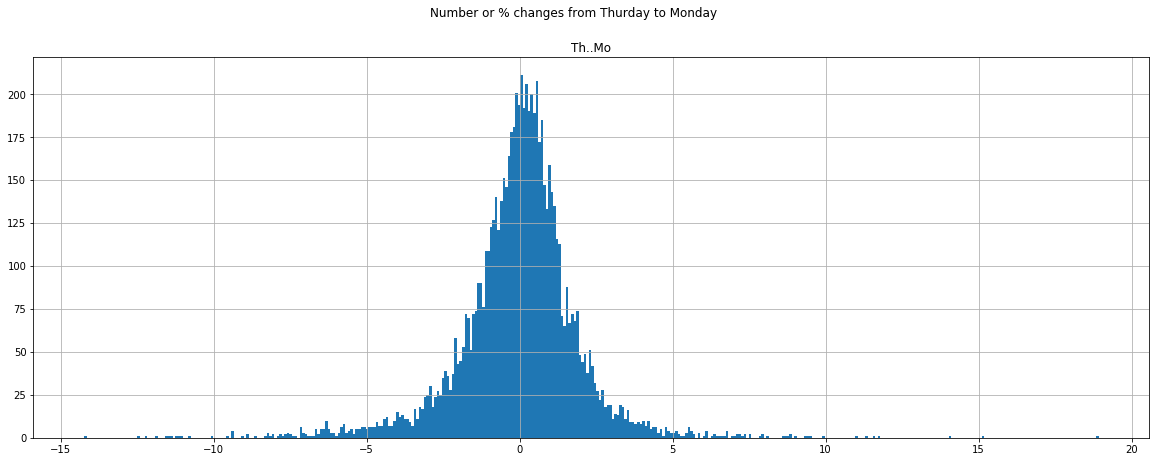

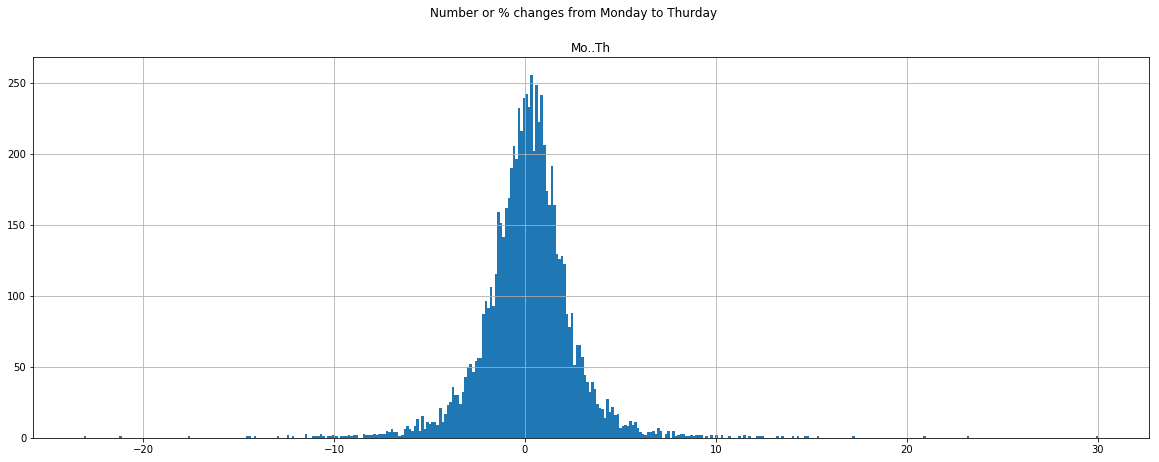

In [68]:
# Check values distribution
hist = dataout.hist(bins=500, figsize=(20,7), column=delta1)
plt.suptitle("Number or % changes from Thurday to Monday")
hist = dataout.hist(bins=500, figsize=(20,7), column=delta2)
plt.suptitle("Number or % changes from Monday to Thurday")